In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plot
import matplotlib.pyplot as plt
import seaborn as sns
import time
import json
from statannotations.Annotator import Annotator
from matplotlib.ticker import FormatStrFormatter

from game import *
from utils import *
from plots import *
from agents import *
from T4T import *
from nni_pop import *

palette = sns.color_palette("colorblind")
sns.set_palette(palette)
sns.set(context='paper', style='white', font='CMU Serif', rc={'font.size':12, 'mathtext.fontset': 'cm'})

In [2]:
def rerun(agents, args, t4tSeedStart=0):
    dfs = []
    for i in range(args['nTest']):
        print(f'test {i}')
        for agent in agents:
            agent.reinitialize(args['player'])
        df = run(agents, nGames=args['nGames'], opponent=args["opponent"], t4tSeed=t4tSeedStart+i).query("ID in @IDs")
        df['t4tSeed'] = [t4tSeedStart+i for _ in range(df.shape[0])]
        dfs.append(df)
    data = pd.concat(dfs, ignore_index=True)
    return data

In [14]:
def tTestAndPlot(emp, sim, args, dependent, defect=False):
    player = args['player']
    opponent = args['opponent']
    gameFinal = 14 - args['nFinal']
    player2 = 'trustee' if player=='investor' else 'investor'
    emp = emp.query('game>@gameFinal')
    sim = sim.query('game>@gameFinal')
    if defect:
        emp = emp.query('turn==4')
        sim = sim.query('turn==4')
    yticks = ((0, 0.2, 0.4, 0.6, 0.8, 1.0)) if dependent=='generosity' else ((0, 5, 10, 15))

    fig, axes = plt.subplots(nrows=1, ncols=2, sharex=True, sharey=True, figsize=((6.38, 2)))
    sns.violinplot(data=emp, x="orientation", y=dependent, order=["proself", "prosocial"], ax=axes[0], palette=palette[2:4], saturation=1, inner='quartile', cut=0, bw=0.2)
    annot = Annotator(pairs=[("proself", "prosocial")], data=emp, x='orientation', y=dependent, order=["proself", "prosocial"], ax=axes[0], plot='violinplot')
    annot.configure(test="t-test_ind", loc='outside', verbose=1).apply_test().annotate()
    axes[0].set(xlabel=None, title=f'humans vs {opponent} {player2}', yticks=yticks)

    sns.violinplot(data=sim, x="orientation", y=dependent, order=["proself", "prosocial"], ax=axes[1], palette=palette[2:4], saturation=1, inner='quartile', cut=0, bw=0.2)
    annot = Annotator(pairs=[("proself", "prosocial")], data=sim, x='orientation', y=dependent, order=["proself", "prosocial"], ax=axes[1], plot='violinplot')
    annot.configure(test="t-test_ind", loc='outside', verbose=1).apply_test().annotate()
    axes[1].set(xlabel=None, ylabel=None, title=f'agent vs {opponent} {player2}', yticks=yticks)

    sns.despine(fig=fig, ax=axes, top=True, right=True, left=False, bottom=False, offset=None, trim=False)
    plt.tight_layout()
    fig.savefig(f"plots/{args['architecture']}_vs_{opponent}_{player2}_{dependent}.png", dpi=600)

In [4]:
def LTPlot(agents, sim, args):
    player2 = 'trustee' if args['player']=='investor' else 'investor'
    IDs = [agent.ID for agent in agents]
    for ID in IDs:
        fig, axes = plt.subplots(nrows=1, ncols=1, figsize=((6.38, 2)))
        sns.histplot(data=sim.query("ID==@ID"), x='game', y='generosity', bins=(15, 11), binrange=((0, args['nGames']),(0, 1)), ax=axes, color=palette[0])
        ax2 = axes.twinx()
        sns.lineplot(data=sim.query("ID==@ID"), x='game', y='coins', ax=ax2, color=palette[1])
        axes.set(title=f'{ID} vs {args["opponent"]} trustee',
            xlabel='Game', ylabel='Generosity', xticks=((0,5,10,15)), yticks=((0.0, 0.2, 0.4, 0.6, 0.8, 1.0)))
        ax2.set(ylabel='Score', yticks=((3,6,9,12,15)))
        plt.tight_layout()
        fig.savefig(f"plots/{ID}_vs_{opponent}_{player2}_LT.png", dpi=600)
        plt.close("all")

In [12]:
f = open('data/IBL')
result = json.load(f)
min_loss = 1000
params = {}
for trial in result:
    loss = float(trial['value'])
    if loss <= min_loss:
        min_loss = loss
        params = trial['parameter']
print(params, min_loss)

{'popSeed': 36, 'thrSVO': 0.17, 'tau': 2.5, 'decay': 0.44, 'sigma': 0.78, 'thrA': -1.25, 'gamma': 0.15} 0.6401326673326674


In [6]:
f = open('data/DQN')
result = json.load(f)
min_loss = 1000
params = {}
for trial in result:
    loss = float(trial['value'])
    if loss <= min_loss:
        min_loss = loss
        params = trial['parameter']
print(params, min_loss)

{'popSeed': 20, 'thrSVO': 0.31, 'tau': 3.7, 'gamma': 0.53, 'alpha': 0.498} 0.47790750915750924


# DQN vs Greedy Trustee

In [154]:
f = open('fixed_space_pop.json')
params = json.load(f)
# params2 = {
#     "popSeed": 78,
#     "tau": 12.9,
#     "alpha": 0.029,
#     "gamma": 0.79
# }
params2 = {
    "popSeed": 22,
    "tau": 19.8,
    "alpha": 0.001,
    "gamma": 0.37
}
args = params | params2
agents = makePopulation(args)
IDs = [agent.ID for agent in agents]
player = args['player']
player2 = 'investor' if player=='trustee' else 'trustee'
opponent = args['opponent']
emp = pd.read_pickle("data/human_data_cleaned.pkl").query('player==@player & opponent==@opponent')

In [155]:
data = rerun(agents, args)

test 0


88 agents selected
proself 55, prosocial 33
p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

proself vs. prosocial: t-test independent samples, P_val:3.526e-01 t=-9.302e-01
p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

proself vs. prosocial: t-test independent samples, P_val:5.568e-02 t=1.915e+00


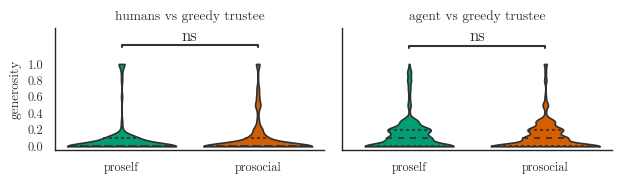

In [156]:
pop, selected = selectLearners(agents, data)
sim, nProself, nProsocial = addLabel(pop, selected, args)
print(f"proself {nProself}, prosocial {nProsocial}")
tTestAndPlot(emp, sim, args, 'generosity')

In [157]:
overlapProself = overlap(emp.query("orientation=='proself'"), sim.query("orientation=='proself'"), args)
overlapProsocial = overlap(emp.query("orientation=='prosocial'"), sim.query("orientation=='prosocial'"), args)
penalty = 1 - overlap(sim.query("orientation=='proself'"), sim.query("orientation=='prosocial'"), args)
print(overlapProself)
print(overlapProsocial)
print(args['penalizeSimilarity']*penalty)

0.3095804195804196
0.2111111111111111
0.0


In [145]:
sim.to_pickle(f"data/{params['architecture']}_vs_{opponent}_{player2}_violin.pkl")

# IBL vs Greedy Trustee

In [148]:
f = open('fixed_space_pop.json')
params = json.load(f)
params2 = {
    "popSeed": 9,
    "tau": 1.6,
    "decay": 0.34,
    "sigma": 0.5700000000000001,
    "thrA": -0.79,
    "gamma": 0.15
}
args = params | params2
agents = makePopulation(args)
IDs = [agent.ID for agent in agents]
player = args['player']
player2 = 'investor' if player=='trustee' else 'trustee'
opponent = args['opponent']
emp = pd.read_pickle("data/human_data_cleaned.pkl").query('player==@player & opponent==@opponent')

In [149]:
data = rerun(agents, args)

test 0


404 agents selected
proself 62, prosocial 342
p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

proself vs. prosocial: t-test independent samples, P_val:3.526e-01 t=-9.302e-01
p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

proself vs. prosocial: t-test independent samples, P_val:1.099e-01 t=-1.599e+00


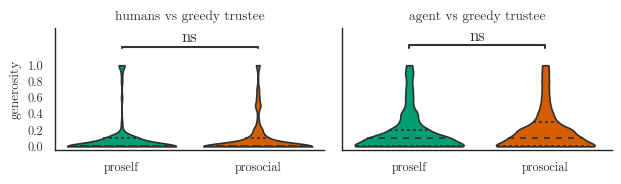

In [150]:
pop, selected = selectLearners(agents, data)
sim, nProself, nProsocial = addLabel(pop, selected, args)
print(f"proself {nProself}, prosocial {nProsocial}")
tTestAndPlot(emp, sim, args, 'generosity')

In [151]:
overlapProself = overlap(emp.query("orientation=='proself'"), sim.query("orientation=='proself'"), args)
overlapProsocial = overlap(emp.query("orientation=='prosocial'"), sim.query("orientation=='prosocial'"), args)
penalty = 1 - overlap(sim.query("orientation=='proself'"), sim.query("orientation=='prosocial'"), args)
print(overlapProself)
print(overlapProsocial)
print(args['penalizeSimilarity']*penalty)

0.351985111662531
0.3567251461988304
0.0


In [152]:
sim.to_pickle(f"data/{params['architecture']}_vs_{opponent}_{player2}_violin.pkl")

# DQN vs Generous Trustee

In [44]:
f = open('fixed_space_pop.json')
params = json.load(f)
# params2 = {
#     "popSeed": 690,
#     "tau": 9.4,
#     "alpha": 0.1299,
#     "gamma": 0.2
# }
# params2 = {
#     "popSeed": 89,
#     "tau": 10.200000000000001,
#     "alpha": 0.054,
#     "gamma": 0.34
# }
# params2 = {
#     "popSeed": 76,
#     "thrSVO": 0.33,
#     "tau": 10.4,
#     "alpha": 0.195,
#     "gamma": 0.77
# }
params2 = {
    "popSeed": 89,
    "thrSVO": 0.33,
    "tau": 12.1,
    "alpha": 0.043,
    "gamma": 0.34
}
# params2 = {'popSeed': 20, 'thrSVO': 0.31, 'tau': 3.7, 'gamma': 0.53, 'alpha': 0.498}
args = params | params2
agents = makePopulation(args)
IDs = [agent.ID for agent in agents]
player = args['player']
player2 = 'investor' if player=='trustee' else 'trustee'
opponent = args['opponent']
emp = pd.read_pickle("data/human_data_cleaned.pkl").query('player==@player & opponent==@opponent')

In [45]:
data = rerun(agents, args)

test 0


105 agents selected
proself 57, prosocial 48
p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

proself vs. prosocial: t-test independent samples, P_val:5.268e-10 t=-6.361e+00
p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

proself vs. prosocial: t-test independent samples, P_val:3.209e-23 t=-1.009e+01


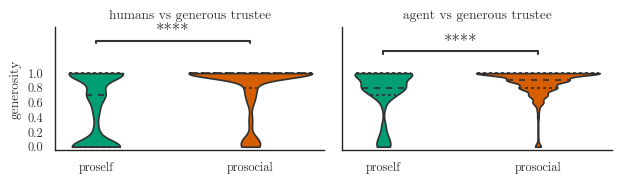

In [28]:
pop, selected = selectLearners(agents, data)
sim, nProself, nProsocial = addLabel(pop, selected, args)
print(f"proself {nProself}, prosocial {nProsocial}")
tTestAndPlot(emp, sim, args, 'generosity')

In [47]:
overlapProself = overlap(emp.query("orientation=='proself'"), sim.query("orientation=='proself'"), args)
overlapProsocial = overlap(emp.query("orientation=='prosocial'"), sim.query("orientation=='prosocial'"), args)
penalty = 1 - overlap(sim.query("orientation=='proself'"), sim.query("orientation=='prosocial'"), args)
print(overlapProself)
print(overlapProsocial)
print(args['penalizeSimilarity']*penalty)

0.27268170426065164
0.225
0.11542763157894737


In [49]:
LTPlot(pop, sim, args)

In [48]:
sim.to_pickle(f"data/{params['architecture']}_vs_{opponent}_{player2}_violin.pkl")

# IBL vs Generous Trustee

In [51]:
f = open('fixed_space_pop.json')
params = json.load(f)
params2 = {'popSeed': 36, 'thrSVO': 0.17, 'tau': 2.5, 'decay': 0.44, 'sigma': 0.78, 'thrA': -1.25, 'gamma': 0.15}
args = params | params2
agents = makePopulation(args)
IDs = [agent.ID for agent in agents]
player = args['player']
player2 = 'investor' if player=='trustee' else 'trustee'
opponent = args['opponent']
emp = pd.read_pickle("data/human_data_cleaned.pkl").query('player==@player & opponent==@opponent')

In [52]:
data = rerun(agents, args)

test 0


168 agents selected
proself 25, prosocial 143
p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

proself vs. prosocial: t-test independent samples, P_val:5.268e-10 t=-6.361e+00
p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

proself vs. prosocial: t-test independent samples, P_val:4.767e-36 t=-1.274e+01


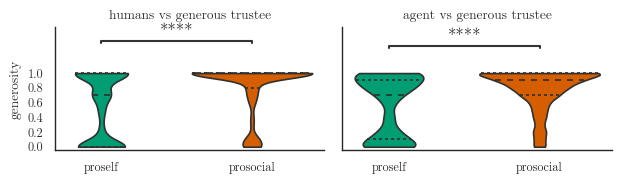

In [53]:
pop, selected = selectLearners(agents, data)
sim, nProself, nProsocial = addLabel(pop, selected, args)
print(f"proself {nProself}, prosocial {nProsocial}")
tTestAndPlot(emp, sim, args, 'generosity')

In [54]:
overlapProself = overlap(emp.query("orientation=='proself'"), sim.query("orientation=='proself'"), args)
overlapProsocial = overlap(emp.query("orientation=='prosocial'"), sim.query("orientation=='prosocial'"), args)
penalty = 1 - overlap(sim.query("orientation=='proself'"), sim.query("orientation=='prosocial'"), args)
print(overlapProself)
print(overlapProsocial)
print(args['penalizeSimilarity']*penalty)

0.17885714285714285
0.34965034965034963
0.11162517482517482


In [58]:
sim.to_pickle(f"data/{params['architecture']}_vs_{opponent}_{player2}_violin.pkl")

In [56]:
LTPlot(pop, sim, args)

# Combine simulated and empirical data

p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

proself vs. prosocial: t-test independent samples, P_val:5.268e-10 t=-6.361e+00
p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

proself vs. prosocial: t-test independent samples, P_val:3.209e-23 t=-1.009e+01
p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

proself vs. prosocial: t-test independent samples, P_val:4.767e-36 t=-1.274e+01


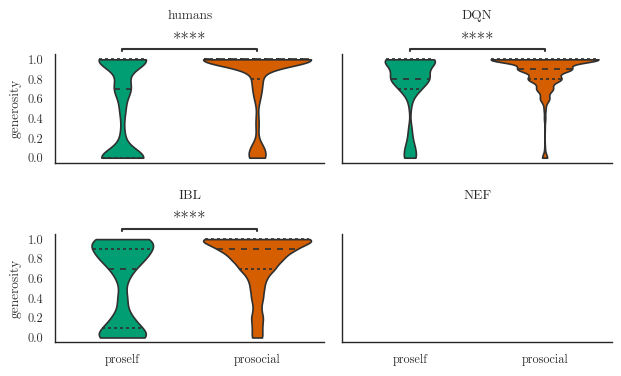

In [89]:
emp = pd.read_pickle("data/human_data_cleaned.pkl").query('player=="investor" & opponent=="generous" & game>11')
dqn = pd.read_pickle(f"data/DQN_vs_generous_trustee_violin.pkl").query("game>11")
ibl = pd.read_pickle(f"data/IBL_vs_generous_trustee_violin.pkl").query("game>11")
fig, axes = plt.subplots(nrows=2, ncols=2, sharex=True, sharey=True, figsize=((6.38, 4)))

sns.violinplot(data=emp, x="orientation", y="generosity", order=["proself", "prosocial"], ax=axes[0][0], palette=palette[2:4], saturation=1, inner='quartile', cut=0, bw=0.2)
annot1 = Annotator(pairs=[("proself", "prosocial")], data=emp, x='orientation', y='generosity', order=["proself", "prosocial"], ax=axes[0][0], plot='violinplot')

sns.violinplot(data=dqn, x="orientation", y="generosity", order=["proself", "prosocial"], ax=axes[0][1], palette=palette[2:4], saturation=1, inner='quartile', cut=0, bw=0.2)
annot2 = Annotator(pairs=[("proself", "prosocial")], data=dqn, x='orientation', y='generosity', order=["proself", "prosocial"], ax=axes[0][1], plot='violinplot')

sns.violinplot(data=ibl, x="orientation", y="generosity", order=["proself", "prosocial"], ax=axes[1][0], palette=palette[2:4], saturation=1, inner='quartile', cut=0, bw=0.2)
annot3 = Annotator(pairs=[("proself", "prosocial")], data=ibl, x='orientation', y='generosity', order=["proself", "prosocial"], ax=axes[1][0], plot='violinplot')

annot1.configure(test="t-test_ind", loc='outside').apply_test().annotate()
annot2.configure(test="t-test_ind", loc='outside').apply_test().annotate()
annot3.configure(test="t-test_ind", loc='outside').apply_test().annotate()

axes[0][0].set(yticks=((0,0.2,0.4,0.6,0.8,1.0)), xlabel=None)
axes[0][1].set(yticks=((0,0.2,0.4,0.6,0.8,1.0)), xlabel=None, ylabel=None)
axes[1][0].set(yticks=((0,0.2,0.4,0.6,0.8,1.0)), xlabel=None)
axes[1][1].set(yticks=((0,0.2,0.4,0.6,0.8,1.0)), xlabel=None, ylabel=None)
axes[0][0].set_title("humans", loc='center', y=1.25)
axes[0][1].set_title("DQN", loc='center', y=1.25)
axes[1][0].set_title("IBL", loc='center', y=1.25)
axes[1][1].set_title("NEF", loc='center', y=1.25)

sns.despine(fig=fig, ax=axes, top=True, right=True, left=False, bottom=False, offset=None, trim=False)

plt.tight_layout()

fig.savefig("plots/sim_Ttest_generosity_generoustrustee.png", dpi=600)

p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

proself vs. prosocial: t-test independent samples, P_val:3.526e-01 t=-9.302e-01
p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

proself vs. prosocial: t-test independent samples, P_val:1.046e-02 t=-2.562e+00
p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

proself vs. prosocial: t-test independent samples, P_val:1.099e-01 t=-1.599e+00


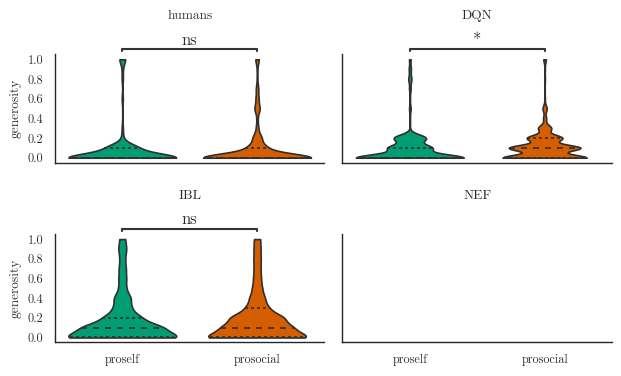

In [153]:
emp = pd.read_pickle("data/human_data_cleaned.pkl").query('player=="investor" & opponent=="greedy" & game>11')
dqn = pd.read_pickle(f"data/DQN_vs_greedy_trustee_violin.pkl").query("game>11")
ibl = pd.read_pickle(f"data/IBL_vs_greedy_trustee_violin.pkl").query("game>11")
fig, axes = plt.subplots(nrows=2, ncols=2, sharex=True, sharey=True, figsize=((6.38, 4)))

sns.violinplot(data=emp, x="orientation", y="generosity", order=["proself", "prosocial"], ax=axes[0][0], palette=palette[2:4], saturation=1, inner='quartile', cut=0, bw=0.2)
annot1 = Annotator(pairs=[("proself", "prosocial")], data=emp, x='orientation', y='generosity', order=["proself", "prosocial"], ax=axes[0][0], plot='violinplot')

sns.violinplot(data=dqn, x="orientation", y="generosity", order=["proself", "prosocial"], ax=axes[0][1], palette=palette[2:4], saturation=1, inner='quartile', cut=0, bw=0.2)
annot2 = Annotator(pairs=[("proself", "prosocial")], data=dqn, x='orientation', y='generosity', order=["proself", "prosocial"], ax=axes[0][1], plot='violinplot')

sns.violinplot(data=ibl, x="orientation", y="generosity", order=["proself", "prosocial"], ax=axes[1][0], palette=palette[2:4], saturation=1, inner='quartile', cut=0, bw=0.2)
annot3 = Annotator(pairs=[("proself", "prosocial")], data=ibl, x='orientation', y='generosity', order=["proself", "prosocial"], ax=axes[1][0], plot='violinplot')

annot1.configure(test="t-test_ind", loc='outside').apply_test().annotate()
annot2.configure(test="t-test_ind", loc='outside').apply_test().annotate()
annot3.configure(test="t-test_ind", loc='outside').apply_test().annotate()

axes[0][0].set(yticks=((0,0.2,0.4,0.6,0.8,1.0)), xlabel=None)
axes[0][1].set(yticks=((0,0.2,0.4,0.6,0.8,1.0)), xlabel=None, ylabel=None)
axes[1][0].set(yticks=((0,0.2,0.4,0.6,0.8,1.0)), xlabel=None)
axes[1][1].set(yticks=((0,0.2,0.4,0.6,0.8,1.0)), xlabel=None, ylabel=None)
axes[0][0].set_title("humans", loc='center', y=1.25)
axes[0][1].set_title("DQN", loc='center', y=1.25)
axes[1][0].set_title("IBL", loc='center', y=1.25)
axes[1][1].set_title("NEF", loc='center', y=1.25)

sns.despine(fig=fig, ax=axes, top=True, right=True, left=False, bottom=False, offset=None, trim=False)

plt.tight_layout()

fig.savefig("plots/sim_Ttest_generosity_greedytrustee.png", dpi=600)

# Late Defect

In [11]:
f = open('fixed_space_pop.json')
params = json.load(f)
params2 = {
    "popSeed": 54,
    "tau": 3,
    "alpha": 0.023,
    "gamma": 0.3
}
args = params | params2
agents = makePopulation(args)
IDs = [agent.ID for agent in agents]
player = args['player']
player2 = 'investor' if player=='trustee' else 'trustee'
opponent = args['opponent']
emp = pd.read_pickle("data/human_data_cleaned.pkl").query('player==@player & opponent==@opponent')

In [12]:
data = rerun(agents, args)

test 0


proself 102, prosocial 98
p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

proself vs. prosocial: t-test independent samples, P_val:8.938e-05 t=-4.044e+00
p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

proself vs. prosocial: t-test independent samples, P_val:9.420e-01 t=-7.282e-02


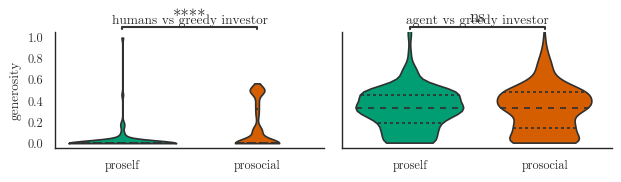

In [15]:
pop, selected = agents, data
sim, nProself, nProsocial = addLabel(pop, selected, args)
print(f"proself {nProself}, prosocial {nProsocial}")
tTestAndPlot(emp, sim, args, 'generosity', defect=True)